In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pandas as pd
import numpy as np

import os
import warnings

from scipy.io import wavfile

from hmmlearn import hmm  
import pomegranate

from python_speech_features import mfcc

from sklearn.externals import joblib

import hmm_model_feature_extraction

import random

import matplotlib.pyplot as plt

from tqdm import tqdm

from ast import literal_eval

from google.cloud import storage

gcp = True

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
if gcp == True:
    
    import gcsfs
    import pickle
    import cupy
    
    mixed_dir = "gs://ad-bucket-15730/mixed_20k"
    hmm_model_dir = "gs://ad-bucket-15730/hmm_models"
    fs = gcsfs.GCSFileSystem(project = 'audio-detection-1')
    pomegranate.utils.enable_gpu()
    print(pomegranate.utils.is_gpu_enabled())
    
    # moving pre-populated validation list for faster model validation
    bucket_name = "ad-bucket-15730"
    validation_dir = "gs://{}/validation".format(bucket_name)
    
    # need to create folder on vm instance
    if "validation" not in os.listdir():
        
        os.mkdir("validation")
        
    # ten arbitrarily chosen    
    if len(os.listdir("validation")) < 10:
        
        os.system("gsutil -m cp {}/* ./validation".format(validation_dir))
        
else:
    
    mixed_dir = "../../../mixed"
    hmm_model_dir = "../../../hmm_models"

True


In [40]:
# name this particular trial
trial_name = "gpu_test_2_multi-dim_multi-state_20-iter"

# initialize feature extraction class
fe = hmm_model_feature_extraction.feature_extraction(mixed_dir="mixed_20k", sampling_freq = 20000, gcp = True)

# load in mixed_metadata
metadata = pd.read_csv(mixed_dir + "/mixed_metadata.csv")

# determine the number of iterations for each HMM
num_iterations = 50

# number of cepstral coefficients to return from mfcc (13 is default)
num_cep_coefs = 13

# whether we will feed concatenated, 2-dimensional cepstral coefficients for each track as a sample
multidimensional_input = True

# whether to use the pomegranate package for fitting hmm
use_pomegranate = True

# what distribution to use for the states 
distribution = pomegranate.MultivariateGaussianDistribution



In [41]:
# re-configuring metadata df if we're using on the cloud given the set-aside validation set:

if gcp == True:

    validation_samples = os.listdir("validation")
    validation_df = metadata[metadata['slice_file_name'].isin(validation_samples)]
    validation_samples = [(validation_df['slice_file_name'].iloc[i], validation_df['class'].iloc[i]) for i in range(len(validation_df))]
    metadata = metadata[~metadata['slice_file_name'].isin(validation_samples)]

In [22]:
# choose hidden states per self-organizing maps

label_states = pd.Series({"air_conditioner":20, "car_horn":18, "children_playing":11,
             "dog_bark":17, "drilling":20, "engine_idling":20,
             "gun_shot":9, "jackhammer":18, "siren":17,
             "street_music":17})

399


Text(0.5, 1.05, 'MFCC')

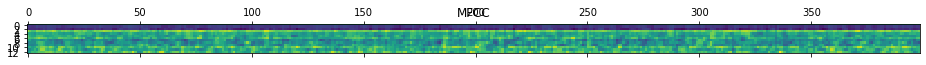

In [23]:
# test data intake

time_signal = fe.read("100852-0-0-13.wav")
mfccs = fe.return_mfcc(time_signal, nfft=1200)
print(mfccs.shape[0])
plt.matshow(mfccs.T)
plt.title('MFCC')

In [24]:
### Define a class to train the HMM ###

# Parameters of `hmm.GaussianHMM()`:
# `n_components`: number of states of HMM
# `covariance_type`: type of covariance matrix for each state. 
# Each state is a random vector. 
# This parameter is a string defining the type of covariance matrix of this vector. Defaults to `"diagonal"`

class HMM_Model(object):
    
    def __init__(self, num_components=12, 
                 num_iter=100,
                use_pomegranate=True,
                distribution=pomegranate.NormalDistribution,
                gpu=False):
        
        self.n_components = num_components
        self.n_iter = num_iter
        self.use_pomegranate = use_pomegranate
        self.distribution = distribution
        
        # define the covariance type and the type of HMM:
        self.cov_type = 'diag'
        self.model_name = 'GaussianHMM'
        
        # initialize the variable in which we will store the models for each word:
        self.models = []
        
        # define the model using the specified parameters:
        if not self.use_pomegranate:

            self.model = hmm.GaussianHMM(n_components=self.n_components,
                                     covariance_type=self.cov_type,
                                     n_iter=self.n_iter, verbose=True)
        
        # we anble pomegranate's gpu utility if gpu is set to true 
        self.gpu = gpu
        if self.gpu==True:
            
            pomegranate.utils.enable_gpu()
            print("pomegranate_gpu is enabled: ", pomegranate.utils.is_gpu_enabled())
            

    def train(self, training_data, multidimensional_input):
        
        """
        Defines a method to train the model
        'training_data' is a 2D numpy array where each row has the 
        length of number of mfcc coefficients
        """
        # for default case using pomegranate package        
        if self.use_pomegranate:
            
            # training on multidimensional input (i.e. n_samples x n_windows x n_cepstral_coefs)
            if multidimensional_input:
                
                print("training on multidimensional input using pomegranate, {} states, {} iterations, and sample shape {}".format(self.n_components,self.n_iter,training_data.shape))
                self.model = pomegranate.HiddenMarkovModel.from_samples(self.distribution, 
                                                                    self.n_components,
                                                                    training_data, 
                                                                    max_iterations=self.n_iter, 
                                                                    algorithm="baum-welch", 
                                                                    n_jobs=-1, 
                                                                    verbose=True)
            
            # training on unidimensional input (i.e. one cepstral grid per track)
            else:
                
                print("training on unidimensional input using pomegranate, {} states, {} iterations, and sample shape {}".format(self.n_components,self.n_iter,training_data.shape))
                self.model = pomegranate.HiddenMarkovModel.from_samples(self.distribution, 
                                                                    self.n_components,
                                                                    training_data, 
                                                                    max_iterations=self.n_iter, 
                                                                    algorithm="baum-welch", 
                                                                    n_jobs=-1, 
                                                                    verbose=True)
                
                
            self.models.append(self.model)
        
        # for alternative case using hmmlearn
        else:
            
            print("training on unidimensional input using pomegranate, {} states, {} iterations, and sample shape {}".format(self.n_components,self.n_iter,training_data.shape))
            np.seterr(all='ignore')
            cur_model = self.model.fit(training_data)
            self.models.append(cur_model)

    
    def compute_score(self, input_data):
        
        """
        Define a method to compute log likelihood score for input features
        Returns: Log likelihood of sample input_data
        """
        if self.use_pomegranate:
            print("scoring input of shape ", input_data.shape, " using pomegranate")
            return self.model.log_probability(input_data)
            
        else:
            print("scoring input of shape ", input_data.shape, " hmmlearn")
            return self.model.score(input_data)

In [25]:
def build_one_model(features_vector, num_states, num_iterations, multidimensional_input, use_pomegranate, distribution, gpu):
    
    """
    features_vector: nparray of features from Class above
    num_states: number of hidden states in HMM
    """
    
    # initiate HMM model object
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model = HMM_Model(num_components=num_states, num_iter=num_iterations, 
                          use_pomegranate=use_pomegranate, distribution=distribution, gpu=gpu)

    # train HMM model, calculate likelihood of the sample by the trained model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model.train(features_vector, multidimensional_input)
        model_score = model.compute_score(features_vector)
        
    return model, model_score

In [26]:
def hmm_aic(LLik, n, k):
    
    """
    Takes in loglikelihood of trained HMM plus number of params
    Returns: Model AIC
    """
    return -2*LLik+2*(n*n+k*n-1)

In [27]:
def build_all_models(label_name, metadata, num_states, num_iterations, training_prop = 0.7, \
                     multidimensional_input=False, use_pomegranate=True, \
                     distribution = pomegranate.NormalDistribution, gpu=False):
    
    """
    Given an input data folder with subfolders for each response label
    """
    
    # empty list for storing model results
    model_results = []
    validation_set = []
    

    # load in filenames relevant to a particular label
    label_file_names = metadata[metadata['class'] == label_name]['slice_file_name'].tolist()
    # reserve 30 percent for validation
    num_to_train = int(np.ceil(len(label_file_names) * training_prop)) # may need to reduce for pomegranate training
    train = random.sample(label_file_names, num_to_train)
    print(label_name,"train length:", len(train))
    validate = list(set(label_file_names) - set(train))
    print(label_name," validation length:", len(validate))
    # append the list of validation filenames and respective label to validation_set
    validation_set.append((validate, label_name))
    
    # for unidimensional inputs
    if multidimensional_input == False:
    
        # create an empty array for appending features
        X = np.array([])
    
        print("loading in files for label: ", label_name)

        for j in tqdm(range(len(train))):
        
            loaded = fe.read(train[j])
            # nfft assumes 44100Hz
            mfcc_features = fe.return_mfcc(loaded, nfft=1200)

            if len(X) == 0:
                
                X = mfcc_features
            
            else:
                
                X = np.append(X, mfcc_features, axis=0)
            
        model = build_one_model(X, num_states, num_iterations, multidimensional_input, \
                                use_pomegranate, distribution, gpu)
        
        # add the model to the results list
        model_results.append((model, label_name))
        
        # reset model variable
        model = None

        return model_results, validation_set
    
    # for multidimensional inputs
    else:
        
        # create an empty array for appending features
        X = np.array([])
    
        print("loading in files for label: ", label_name)
        
        # need to count the number of samples not discarded
        counter = 0
        for j in tqdm(range(len(train))):
        
            loaded = fe.read(train[j])
            # nfft assumes 44100Hz
            mfcc_features = fe.return_mfcc(loaded, nfft=1200)
            
            # need to have all mfcc features the same 
            if mfcc_features.shape[0] == 399: # this number likely not robust to other sampling rates

                if len(X) == 0:
                
                    X = mfcc_features
                    counter += 1
            
                else:
                
                    X = np.append(X, mfcc_features, axis=0)
                    counter += 1
                    
            else:
                
                pass
        
        # (n_samples x n_windows x n_cepstral_coefs)
        X = X.reshape(counter, 399, num_cep_coefs) # this number likely not robust to other sampling rates
        model = build_one_model(X, num_states, num_iterations, multidimensional_input, \
                                use_pomegranate, distribution, gpu)
        
        # add the model to the results list
        model_results.append((model, label_name))
        
        # Reset model variable
        model = None

        return model_results, validation_set
                
                
        
        
        


In [28]:
"""
Initiate Training
"""

# empty list to which to append fitted hmms and validation sets

models, validation_sample = [],[]

# loop through each of the labels
for i in range(len(label_states.index)):
    
    # extract the label name
    label_name = label_states.index[i]
    # extract corresponding chosen number of states
    num_states = label_states[label_states.index[i]]
    
    # send through model build functions
    ### we make training_prop = 1 when on the cloud ###
    model_results, validation_set = build_all_models(label_name, metadata, num_states, num_iterations, \
                                                     training_prop = 1, \
                                                     multidimensional_input = multidimensional_input, \
                                                     use_pomegranate = use_pomegranate, \
                                                     distribution = distribution, \
                                                    gpu=True)
    models.append(model_results)
    validation_sample.append(validation_set)
    

  0%|          | 0/2384 [00:00<?, ?it/s]

air_conditioner train length: 2384
air_conditioner  validation length: 0
loading in files for label:  air_conditioner


100%|██████████| 2384/2384 [05:39<00:00,  7.02it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 20 states, 50 iterations, and sample shape (2376, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001678
Total Training Improvement: 0.0
Total Training Time (s): 0.0543
scoring input of shape  (2376, 399, 13)  using pomegranate


  0%|          | 0/1050 [00:00<?, ?it/s]

car_horn train length: 1050
car_horn  validation length: 0
loading in files for label:  car_horn


100%|██████████| 1050/1050 [02:00<00:00,  8.74it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 18 states, 50 iterations, and sample shape (502, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001681
Total Training Improvement: 0.0
Total Training Time (s): 0.0054
scoring input of shape  (502, 399, 13)  using pomegranate


  0%|          | 1/2381 [00:00<04:06,  9.67it/s]

children_playing train length: 2381
children_playing  validation length: 0
loading in files for label:  children_playing


100%|██████████| 2381/2381 [05:33<00:00,  7.14it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 11 states, 50 iterations, and sample shape (2299, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001464
Total Training Improvement: 0.0
Total Training Time (s): 0.0354
scoring input of shape  (2299, 399, 13)  using pomegranate


  0%|          | 0/2436 [00:00<?, ?it/s]

dog_bark train length: 2436
dog_bark  validation length: 0
loading in files for label:  dog_bark


100%|██████████| 2436/2436 [05:01<00:00,  8.09it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 17 states, 50 iterations, and sample shape (1645, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001581
Total Training Improvement: 0.0
Total Training Time (s): 0.0318
scoring input of shape  (1645, 399, 13)  using pomegranate


  0%|          | 1/2386 [00:00<06:19,  6.28it/s]

drilling train length: 2386
drilling  validation length: 0
loading in files for label:  drilling


100%|██████████| 2386/2386 [05:06<00:00,  7.78it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 20 states, 50 iterations, and sample shape (1918, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001478
Total Training Improvement: 0.0
Total Training Time (s): 0.0364
scoring input of shape  (1918, 399, 13)  using pomegranate


  0%|          | 1/2389 [00:00<06:49,  5.83it/s]

engine_idling train length: 2389
engine_idling  validation length: 0
loading in files for label:  engine_idling


100%|██████████| 2389/2389 [05:27<00:00,  7.29it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 20 states, 50 iterations, and sample shape (2296, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001838
Total Training Improvement: 0.0
Total Training Time (s): 0.0561
scoring input of shape  (2296, 399, 13)  using pomegranate


  0%|          | 1/878 [00:00<01:36,  9.05it/s]

gun_shot train length: 878
gun_shot  validation length: 0
loading in files for label:  gun_shot


  0%|          | 0/2408 [00:00<?, ?it/s]

pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 9 states, 50 iterations, and sample shape (41, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0003097
Total Training Improvement: 0.0
Total Training Time (s): 0.0027
scoring input of shape  (41, 399, 13)  using pomegranate
jackhammer train length: 2408
jackhammer  validation length: 0
loading in files for label:  jackhammer


100%|██████████| 2408/2408 [05:12<00:00,  7.70it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 18 states, 50 iterations, and sample shape (1951, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001945
Total Training Improvement: 0.0
Total Training Time (s): 0.0434
scoring input of shape  (1951, 399, 13)  using pomegranate


  0%|          | 0/2209 [00:00<?, ?it/s]

siren train length: 2209
siren  validation length: 0
loading in files for label:  siren


100%|██████████| 2209/2209 [04:59<00:00,  7.38it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 17 states, 50 iterations, and sample shape (2133, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001616
Total Training Improvement: 0.0
Total Training Time (s): 0.0408
scoring input of shape  (2133, 399, 13)  using pomegranate


  0%|          | 1/2436 [00:00<05:34,  7.27it/s]

street_music train length: 2436
street_music  validation length: 0
loading in files for label:  street_music


100%|██████████| 2436/2436 [05:44<00:00,  7.07it/s]


pomegranate_gpu is enabled:  True
training on multidimensional input using pomegranate, 17 states, 50 iterations, and sample shape (2436, 399, 13)
[1] Improvement: 0.0	Time (s): 0.0001736
Total Training Improvement: 0.0
Total Training Time (s): 0.0593
scoring input of shape  (2436, 399, 13)  using pomegranate


In [30]:
models

[[((<__main__.HMM_Model at 0x7f6a80610cf8>, -105492.75657460364),
   'air_conditioner')],
 [((<__main__.HMM_Model at 0x7f6a80610940>, -22037.906184785454), 'car_horn')],
 [((<__main__.HMM_Model at 0x7f6a80e1a9e8>, -97672.523136716),
   'children_playing')],
 [((<__main__.HMM_Model at 0x7f6a8061b630>, -73561.26404492122), 'dog_bark')],
 [((<__main__.HMM_Model at 0x7f6a805fd438>, -84669.94979091972), 'drilling')],
 [((<__main__.HMM_Model at 0x7f6a8048fe10>, -96174.10823416575),
   'engine_idling')],
 [((<__main__.HMM_Model at 0x7f6a80419080>, -1669.9264783365345), 'gun_shot')],
 [((<__main__.HMM_Model at 0x7f6a80474ac8>, -81018.41662892162),
   'jackhammer')],
 [((<__main__.HMM_Model at 0x7f6a80615eb8>, -95453.03698144322), 'siren')],
 [((<__main__.HMM_Model at 0x7f6a803cb160>, -107079.75395971509),
   'street_music')]]

In [44]:
# format validation_sample outputs for validation

if gcp == False:
    
    validation_samples = [(validation_sample[0][0][0][i],validation_sample[0][0][1]) for i in range(len(validation_sample[0][0][0]))] + \
[(validation_sample[1][0][0][i],validation_sample[1][0][1]) for i in range(len(validation_sample[1][0][0]))] + \
[(validation_sample[2][0][0][i],validation_sample[2][0][1]) for i in range(len(validation_sample[2][0][0]))] + \
[(validation_sample[3][0][0][i],validation_sample[3][0][1]) for i in range(len(validation_sample[3][0][0]))] + \
[(validation_sample[4][0][0][i],validation_sample[4][0][1]) for i in range(len(validation_sample[4][0][0]))] + \
[(validation_sample[5][0][0][i],validation_sample[5][0][1]) for i in range(len(validation_sample[5][0][0]))] + \
[(validation_sample[6][0][0][i],validation_sample[6][0][1]) for i in range(len(validation_sample[6][0][0]))] + \
[(validation_sample[7][0][0][i],validation_sample[7][0][1]) for i in range(len(validation_sample[7][0][0]))] + \
[(validation_sample[8][0][0][i],validation_sample[8][0][1]) for i in range(len(validation_sample[8][0][0]))] + \
[(validation_sample[9][0][0][i],validation_sample[9][0][1]) for i in range(len(validation_sample[9][0][0]))]

In [28]:
# convert to validation_samples to txt

if gcp == True:
    
    with fs.open('ad-bucket-15730/hmm_models/validation_samples_{}.txt'.format(trial_name),'w') as file:
        for ele in validation_samples:
            file.write(str(ele) + "\n")
    
    file.close()
    
else:
    
    with open(hmm_model_dir + 'validation_samples_{}.txt'.format(trial_name),'w') as file:
        for ele in validation_samples:
            file.write(str(ele)+'\n')
    
    file.close()

In [19]:
### in case you stop before validation ####

"""
f = fs.open('ad-bucket-15730/hmm_models/validation_samples_{}.txt'.format(trial_name),'r')
validation_samples = f.readlines()
f.close()
validation_samples = [literal_eval(validation_samples[i]) for i in range(len(validation_samples))]

"""

In [45]:
# model save to pkl

if gcp == True:

    with fs.open('ad-bucket-15730/hmm_models/model_{}.pkl'.format(trial_name), 'wb') as file:
        pickle.dump(models, file)
        
else:
    
    joblib.dump(models,hmm_model_dir+'/model{}.pkl'.format(trial_name))
    

In [46]:
# load model from pkl

if gcp == True:
    
    with fs.open('ad-bucket-15730/hmm_models/model_{}.pkl'.format(trial_name), 'rb') as file:
        asdf = pickle.load(file)
        
else:

    trained_models = joblib.load(hmm_model_dir+'/model_{}.pkl'.format(trial_name))

In [47]:
asdf

[[((<__main__.HMM_Model at 0x7f6a8046a4e0>, -105492.75657460364),
   'air_conditioner')],
 [((<__main__.HMM_Model at 0x7f6a8149b898>, -22037.906184785454), 'car_horn')],
 [((<__main__.HMM_Model at 0x7f6a80605e48>, -97672.523136716),
   'children_playing')],
 [((<__main__.HMM_Model at 0x7f6a803cba20>, -73561.26404492122), 'dog_bark')],
 [((<__main__.HMM_Model at 0x7f6a803cbd30>, -84669.94979091972), 'drilling')],
 [((<__main__.HMM_Model at 0x7f6a80419b70>, -96174.10823416575),
   'engine_idling')],
 [((<__main__.HMM_Model at 0x7f6a80419ef0>, -1669.9264783365345), 'gun_shot')],
 [((<__main__.HMM_Model at 0x7f6a804197f0>, -81018.41662892162),
   'jackhammer')],
 [((<__main__.HMM_Model at 0x7f6a8042c128>, -95453.03698144322), 'siren')],
 [((<__main__.HMM_Model at 0x7f6a8042cfd0>, -107079.75395971509),
   'street_music')]]

In [18]:
trained_models

[[((<__main__.HMM_Model at 0x1c1eb389d0>, -80102.11350754816),
   'air_conditioner')],
 [((<__main__.HMM_Model at 0x1b1d975ed0>, -16931.410792991417), 'car_horn')],
 [((<__main__.HMM_Model at 0x1c1e9623d0>, -87839.82903534864),
   'children_playing')],
 [((<__main__.HMM_Model at 0x1c1e962490>, -60292.65693878569), 'dog_bark')],
 [((<__main__.HMM_Model at 0x1c1eb9aa90>, -71055.81563962506), 'drilling')],
 [((<__main__.HMM_Model at 0x1c1ebf5590>, -78008.93994351785),
   'engine_idling')],
 [((<__main__.HMM_Model at 0x1c1eb9a850>, -1110.9918373460123), 'gun_shot')],
 [((<__main__.HMM_Model at 0x1c1ea04f50>, -63477.56404528492), 'jackhammer')],
 [((<__main__.HMM_Model at 0x1c1ed00d50>, -77886.51982565396), 'siren')],
 [((<__main__.HMM_Model at 0x1c1eb0cc10>, -88849.50451911007),
   'street_music')]]

In [50]:
def score_one_sample(trained_models, test_file_name):
    
    """
    trained_model: ModelHMM object with trained model
    test_file_path: path to wav file
    """
    # empty list to hold all of the scores
    scores = []
    
    # load in file from validation set and convert to mfcc features
    fe = hmm_model_feature_extraction.feature_extraction(mixed_dir="validation/", sampling_freq = 20000, gcp = False)
    loaded = fe.read(test_file_name)
    mfcc_features = fe.return_mfcc(loaded, nfft=1200)
    
    # iterate through each of the trained models
    for i in trained_models:
        
        # compute log likelihood score for using each of the trained models
        sample_score = i[0][0][0].compute_score(mfcc_features)
        scores.append(sample_score)
        
    predicted = scores.index(max(scores))
    print("max score is:", max(scores), "at index:", predicted)
    predicted = trained_models[predicted][0][1]
   
    return predicted

In [ ]:
points = 0
validation_list = []

for i in tqdm(range(len(validation_samples))):
    
    print("validation sample size: ", len(validation_samples))
    actual = validation_samples[i][1]
    print("actual:", actual)
    predicted = score_one_sample(asdf, validation_samples[i][0])
    print("predicted:", predicted)
    validation_list.append((actual,predicted))
    if actual == predicted:
        
        points += 1
        print("scored a point!")
        print(points, "points")

  0%|          | 0/5239 [00:00<?, ?it/s]

validation sample size:  5239
actual: dog_bark
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate


  0%|          | 1/5239 [00:00<1:17:16,  1.13it/s]

scoring input of shape  (31, 13)  using pomegranate
scoring input of shape  (31, 13)  using pomegranate
max score is: -1584.6068940490375 at index: 3
predicted: dog_bark
scored a point!
1 points
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 2/5239 [00:12<5:47:04,  3.98s/it]

max score is: -18623.327360241896 at index: 2
predicted: children_playing
scored a point!
2 points
validation sample size:  5239
actual: car_horn
scoring input of shape  (40, 13)  using pomegranate
scoring input of shape  (40, 13)  using pomegranate
scoring input of shape  (40, 13)  using pomegranate
scoring input of shape  (40, 13)  using pomegranate
scoring input of shape  (40, 13)  using pomegranate
scoring input of shape  (40, 13)  using pomegranate
scoring input of shape  (40, 13)  using pomegranate
scoring input of shape  (40, 13)  using pomegranate
scoring input of shape  (40, 13)  using pomegranate
scoring input of shape  (40, 13)  using pomegranate


  0%|          | 3/5239 [00:13<4:33:15,  3.13s/it]

max score is: -2052.0537162265014 at index: 1
predicted: car_horn
scored a point!
3 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 4/5239 [00:24<8:08:41,  5.60s/it]

max score is: -19757.97573196078 at index: 3
predicted: dog_bark
scored a point!
4 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 5/5239 [00:35<10:39:41,  7.33s/it]

max score is: -20217.41438809054 at index: 3
predicted: dog_bark
scored a point!
5 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 6/5239 [00:47<12:21:54,  8.51s/it]

max score is: -19878.791165979557 at index: 3
predicted: dog_bark
scored a point!
6 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 7/5239 [00:58<13:32:54,  9.32s/it]

max score is: -17105.56967497138 at index: 0
predicted: air_conditioner
scored a point!
7 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 8/5239 [01:09<14:20:04,  9.87s/it]

max score is: -17045.530687899616 at index: 0
predicted: air_conditioner
scored a point!
8 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 9/5239 [01:20<14:55:13, 10.27s/it]

max score is: -17076.68268876101 at index: 0
predicted: air_conditioner
scored a point!
9 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 10/5239 [01:31<15:18:56, 10.54s/it]

max score is: -17172.86834320622 at index: 0
predicted: air_conditioner
scored a point!
10 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 11/5239 [01:43<15:36:40, 10.75s/it]

max score is: -17076.951036516137 at index: 0
predicted: air_conditioner
scored a point!
11 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 12/5239 [01:54<15:51:37, 10.92s/it]

max score is: -17146.930579308075 at index: 0
predicted: air_conditioner
scored a point!
12 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 13/5239 [02:05<15:58:34, 11.01s/it]

max score is: -18558.17714776612 at index: 4
predicted: drilling
validation sample size:  5239
actual: children_playing
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 14/5239 [02:16<16:04:09, 11.07s/it]

max score is: -19824.21663556433 at index: 2
predicted: children_playing
scored a point!
13 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 15/5239 [02:28<16:07:54, 11.12s/it]

max score is: -19736.439439592195 at index: 3
predicted: dog_bark
scored a point!
14 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 16/5239 [02:39<16:12:03, 11.17s/it]

max score is: -17425.162899481144 at index: 0
predicted: air_conditioner
scored a point!
15 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 17/5239 [02:50<16:12:26, 11.17s/it]

max score is: -17427.108190616178 at index: 0
predicted: air_conditioner
scored a point!
16 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 18/5239 [03:01<16:13:25, 11.19s/it]

max score is: -17400.9352949732 at index: 0
predicted: air_conditioner
scored a point!
17 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 19/5239 [03:13<16:14:24, 11.20s/it]

max score is: -17357.643082299524 at index: 0
predicted: air_conditioner
scored a point!
18 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 20/5239 [03:24<16:13:27, 11.19s/it]

max score is: -17452.716924697463 at index: 0
predicted: air_conditioner
scored a point!
19 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 21/5239 [03:35<16:11:34, 11.17s/it]

max score is: -17515.29819460625 at index: 0
predicted: air_conditioner
scored a point!
20 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 22/5239 [03:46<16:13:35, 11.20s/it]

max score is: -17426.893833624315 at index: 0
predicted: air_conditioner
scored a point!
21 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 23/5239 [03:58<16:18:25, 11.25s/it]

max score is: -17490.355852927143 at index: 0
predicted: air_conditioner
scored a point!
22 points
validation sample size:  5239
actual: air_conditioner
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 24/5239 [04:09<16:17:22, 11.25s/it]

max score is: -17364.48822536548 at index: 0
predicted: air_conditioner
scored a point!
23 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 25/5239 [04:20<16:15:17, 11.22s/it]

max score is: -18622.097570122354 at index: 9
predicted: street_music
scored a point!
24 points
validation sample size:  5239
actual: street_music
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  0%|          | 26/5239 [04:31<16:15:54, 11.23s/it]

max score is: -18754.86323678294 at index: 9
predicted: street_music
scored a point!
25 points
validation sample size:  5239
actual: dog_bark
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  1%|          | 27/5239 [04:42<16:15:53, 11.23s/it]

max score is: -18701.471044499634 at index: 2
predicted: children_playing
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  1%|          | 28/5239 [04:54<16:15:24, 11.23s/it]

max score is: -18325.520228808142 at index: 8
predicted: siren
scored a point!
26 points
validation sample size:  5239
actual: siren
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  1%|          | 29/5239 [05:05<16:16:04, 11.24s/it]

max score is: -18316.017912986114 at index: 8
predicted: siren
scored a point!
27 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  1%|          | 30/5239 [05:16<16:15:58, 11.24s/it]

max score is: -16943.245491727288 at index: 5
predicted: engine_idling
scored a point!
28 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  1%|          | 31/5239 [05:27<16:15:18, 11.24s/it]

max score is: -16825.425816588977 at index: 5
predicted: engine_idling
scored a point!
29 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 7, in array
    def array(obj, dtype=None, copy=True, order='K', subok=False, ndmin=0):
KeyboardInterrupt


scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 7, in array
    def array(obj, dtype=None, copy=True, order='K', subok=False, ndmin=0):
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 43, in array
    return core.array(obj, dtype, copy, order, subok, ndmin)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 43, in array
    return core.array(obj, dtype, copy, order, subok, ndmin)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 43, in array
    return core.array(obj, dtype, copy, order, subok, ndmin)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/linalg/product.py", line 35, in dot
    return a.dot(b, out)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 43, in array
    return core.array(obj, dtype, copy, order, subok, ndmin)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/linalg/product.py", line 35, in dot
    return a.dot(b, out)
KeyboardInterrupt


scoring input of shape  (399, 13)  using pomegranate


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 43, in array
    return core.array(obj, dtype, copy, order, subok, ndmin)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 43, in array
    return core.array(obj, dtype, copy, order, subok, ndmin)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 43, in array
    return core.array(obj, dtype, copy, order, subok, ndmin)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 43, in array
    return core.array(obj, dtype, copy, order, subok, ndmin)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 43, in array
    return core.array(obj, dtype, copy, order, subok, ndmin)
KeyboardInterrupt


scoring input of shape  (399, 13)  using pomegranate


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 7, in array
    def array(obj, dtype=None, copy=True, order='K', subok=False, ndmin=0):
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 43, in array
    return core.array(obj, dtype, copy, order, subok, ndmin)
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution._log_probability'
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/cupy/creation/from_data.py", line 7, in array
    def array(obj, dtype=None, copy=True, order='K', subok=False, ndmin=0):
KeyboardInterrupt
  1%|          | 32/5239 [05:39<16:19:41, 11.29s/it]

max score is: -16850.400808964052 at index: 5
predicted: engine_idling
scored a point!
30 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


  1%|          | 33/5239 [05:50<16:19:35, 11.29s/it]

max score is: -16905.555632495918 at index: 5
predicted: engine_idling
scored a point!
31 points
validation sample size:  5239
actual: engine_idling
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate
scoring input of shape  (399, 13)  using pomegranate


In [20]:
# print overall accuracy

overall_accuracy = points/len(validation_samples)
overall_accuracy

0.6865614660218885

In [21]:
validation_performance_df = pd.DataFrame(validation_list, columns = ['actual', 'predicted']) 

In [22]:
# save validation performance to hmm_models

if gcp == True:
    
    validation_performance_df.to_csv(hmm_model_dir + '/validation_performance_{}.csv'.format(trial_name))
    label_states.to_csv(hmm_model_dir + '/label_states_{}.csv'.format(trial_name))
    
else:
    
    validation_performance_df.to_csv(hmm_model_dir + '/validation_performance_multidim_50iter_multiple_states.csv')
    label_states.to_csv(hmm_model_dir + '/label_states_{}.csv'.format(trial_name))